In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

np.random.seed(0) 
X = np.random.rand(400, 2) * 2 - 1
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=0)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [2]:
X_train_tensor.shape,X_val_tensor.shape,X_test_tensor.shape

(torch.Size([150, 2]), torch.Size([50, 2]), torch.Size([200, 2]))

In [3]:
def plot_decision_boundary(model, X, y, title=""):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid).round().numpy()
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    plt.title(title)
    plt.show()


In [4]:
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=8, output_size=1, regularization=None, reg_lambda=0.0):
        super(MLP, self).__init__()
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.activation(self.out(x))
        return x
    
    def compute_loss(self, y_pred, y_true):
        loss = nn.BCELoss()(y_pred, y_true)
        
        if self.regularization == 'L1':
            l1_norm = sum(p.abs().sum() for p in self.parameters())
            loss += self.reg_lambda * l1_norm
        elif self.regularization == 'L2':
            l2_norm = sum(p.pow(2.0).sum() for p in self.parameters())
            loss += self.reg_lambda * l2_norm
        return loss


In [5]:
def train_and_validate(model, X_train, y_train, X_val, y_val, epochs=1000, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = model.compute_loss(y_pred, y_train)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val).round()
        accuracy_val = accuracy_score(y_val.numpy(), y_pred_val.numpy())
    return accuracy_val

def find_best_lambda(regularization, lambdas=[0.001, 0.01, 0.1, 1.0]):
    best_lambda = None
    best_accuracy = 0
    for reg_lambda in lambdas:
        model = MLP(regularization=regularization, reg_lambda=reg_lambda)
        accuracy_val = train_and_validate(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
        print(f"Validation Accuracy with lambda={reg_lambda}: {accuracy_val*100:.2f}%")
        if accuracy_val > best_accuracy:
            best_accuracy = accuracy_val
            best_lambda = reg_lambda
    print(f"Best lambda for {regularization}: {best_lambda} with validation accuracy: {best_accuracy*100:.2f}%")
    return best_lambda

best_lambda_L1 = find_best_lambda(regularization='L1')
best_lambda_L2 = find_best_lambda(regularization='L2')


Validation Accuracy with lambda=0.001: 96.00%
Validation Accuracy with lambda=0.01: 54.00%
Validation Accuracy with lambda=0.1: 54.00%
Validation Accuracy with lambda=1.0: 54.00%
Best lambda for L1: 0.001 with validation accuracy: 96.00%
Validation Accuracy with lambda=0.001: 100.00%
Validation Accuracy with lambda=0.01: 96.00%
Validation Accuracy with lambda=0.1: 54.00%
Validation Accuracy with lambda=1.0: 54.00%
Best lambda for L2: 0.001 with validation accuracy: 100.00%


MLP with L1 Regularization
0.995


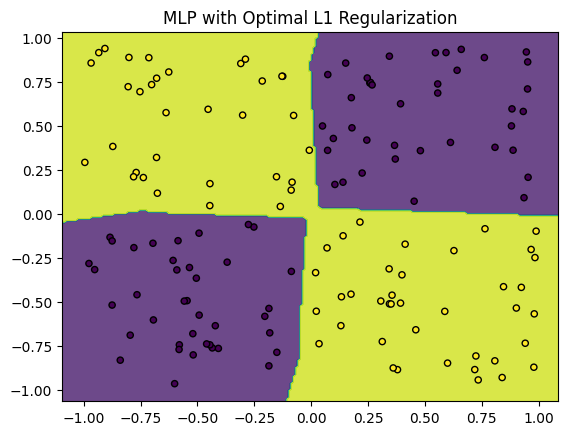

MLP with L2 Regularization
0.995


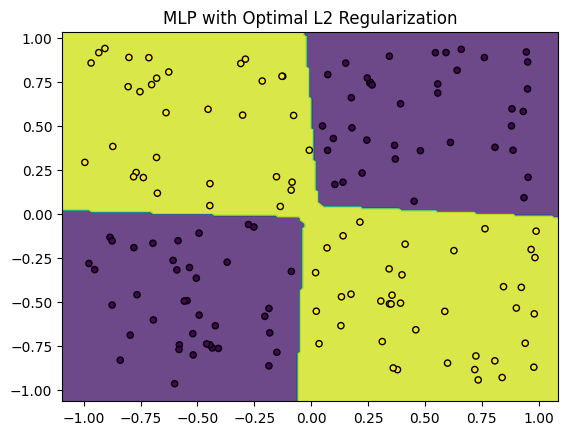

In [6]:
print("MLP with L1 Regularization")
model_L1 = MLP(regularization='L1', reg_lambda=best_lambda_L1)
trained_model_L1 = train_and_validate(model_L1, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
print(trained_model_L1)
plot_decision_boundary(model_L1, X_train, y_train, title="MLP with Optimal L1 Regularization")

print("MLP with L2 Regularization")
model_L2 = MLP(regularization='L2', reg_lambda=best_lambda_L2)
trained_model_L2 = train_and_validate(model_L2, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
print(trained_model_L2)
plot_decision_boundary(model_L2, X_train, y_train, title="MLP with Optimal L2 Regularization")

MLP without Regularization


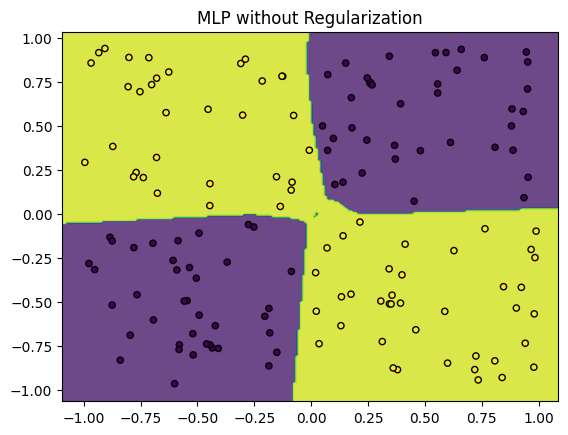

0.975


In [7]:
print("MLP without Regularization")
model_no_reg = MLP(regularization=None)
trained_model_no_reg = train_and_validate(model_no_reg, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
plot_decision_boundary(model_no_reg, X_train, y_train, title="MLP without Regularization")
print(trained_model_no_reg)

Logistic Regression with Polynomial Features
Accuracy: 96.00%


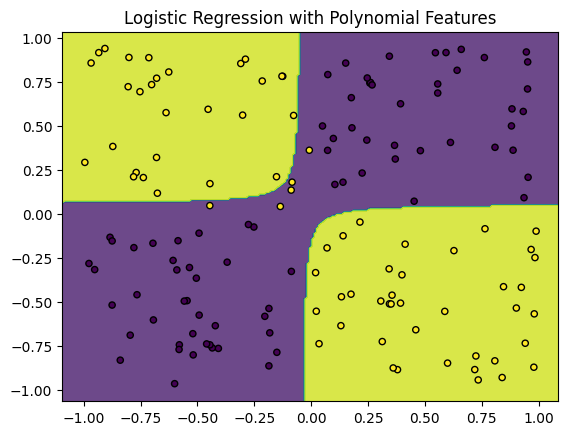

In [8]:
print("Logistic Regression with Polynomial Features")
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_poly, y_train)
y_pred_logreg = logreg.predict(X_test_poly)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy: {accuracy_logreg*100:.2f}%")

def plot_logistic_regression_boundary(model, X, y, poly):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid_poly = poly.transform(np.c_[xx.ravel(), yy.ravel()])
    Z = model.predict(grid_poly)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    plt.title("Logistic Regression with Polynomial Features")
    plt.show()

plot_logistic_regression_boundary(logreg, X_train, y_train, poly)
